In [1]:
import os
import pandas as pd
from glob import glob
from tensorboard.backend.event_processing import event_accumulator
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import torch

# 1. Tensorboard Scalars exportation

Event files in TensorBoard are binary log files generated by the SummaryWriter class to record information about runs. These files, typically named events.out.tfevents.<timestamp>.<hostname>, store various types of data such as scalar metrics (e.g., loss, accuracy), histograms, images, and text summaries. In this section, we extract the information of such files and export them to dataframes.

## 1.1. Where is your parent log folder ?

First, you need to locate the parent log folder containing all experiment subfolders.

In [2]:
log_parent_folder = './results/models'
tb_event_files = glob(os.path.join(log_parent_folder, '**', '*events.out.*'))
print('Found {} experimentations : '.format(len(tb_event_files)))
for i in tb_event_files:
    print('    - {}'.format(i))

Found 2 experimentations : 
    - ./results/models/SimpleSpikingMNET_355f/events.out.tfevents.1733921483.kaptios-bniepce.58951.0
    - ./results/models/SimpleSpikingMNET_e356/events.out.tfevents.1733917708.kaptios-bniepce.21014.0


## 1.2. Create dataframes for each experimentation

We can now check the conversion of one of these files into a dataframe. This dataframe should hold the scalars for its respective experimentation. Its rows contain every step / value couple associated to their respective tag (a tag is something like train/loss, train/acc ...). The following function exports the scalars from the event file and convert them to a dataframe.

In [3]:
def get_event_df(event_file_path):
    event_data = []
    ea = event_accumulator.EventAccumulator(event_file_path)
    ea.Reload()
    
    for tag in ea.Tags().get('scalars', []):
        scalar_events = ea.Scalars(tag)
        for event in scalar_events:
            event_data.append({
                "tag": tag,
                "step": event.step,
                "value": event.value
            })
    return pd.DataFrame(event_data)

You can now access the train/acc and val/acc curves like so : 

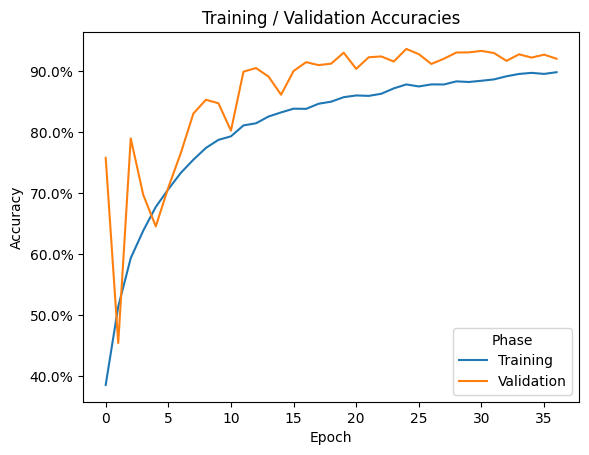

In [13]:
df = get_event_df(tb_event_files[0])
train_acc = df[df['tag'] == 'train/acc']
val_acc = df[df['tag'] == 'val/acc']

sns.lineplot(data=train_acc, x='step', y='value', label='Training')
sns.lineplot(data=val_acc, x='step', y='value', label='Validation')

formatter = FuncFormatter(lambda x, _: f'{x*100:.1f}%')
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Training / Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend(title='Phase')
plt.show()

# 2. Retrieve experimentation parameters and wrap it up

We can use the .pth file to load the experimentation parameters and use them in our plots for title and legends.

In [25]:
def get_checkpoint_file(event_file_path):
    parent_dir = os.path.dirname(event_file_path)
    pth_file = glob(parent_dir + '/*.pth')[0]
    return torch.load(pth_file, weights_only=True)

ckpt_dict = get_checkpoint_file(tb_event_files[0])
print(ckpt_dict['params'])

{'variables': {'image_size': 224, 'n_class': 3, 'n_input': 1}, 'model': {'name': 'SimpleSpikingMNET', 'module_name': 'src.models.jelly', 'parameters': {'input_shape': (1, 224, 224), 'n_output': 3, 'n_steps': 5, 'encoding_method': 'poisson'}}, 'dataset': {'name': 'CustomImageFolder', 'module_name': 'src.datasets.custom', 'parameters': {'root': '/mnt/d/datasets/Vindr/prepared/vindr/lesions/', 'image_size': 224, 'augment_type': 'all'}}, 'dataloader': {'parameters': {'batch_size': 8}}, 'experiment': {'name': 'SJellyExperiment', 'module_name': 'src.experiment.jelly', 'parameters': {'num_epochs': 37, 'lr': 0.0001, 'weight_decay': 0, 'seed': 1234, 'log_dir': './logs', 'early_stopping_patience': 20}}}


Now we have access to the parameters (saved from the .yaml files), we can loop through all event files and create a figure with subplots.

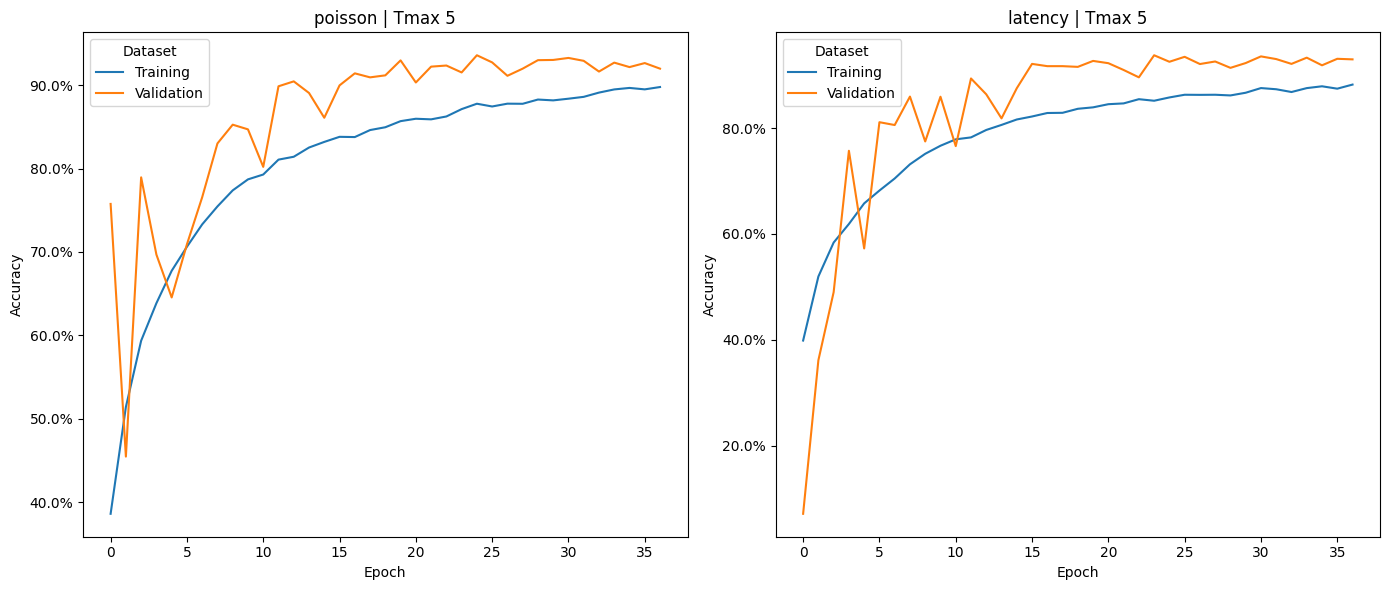

: 

In [ ]:
number_of_subplots = len(tb_event_files)
fig, axes = plt.subplots(1, number_of_subplots, figsize=(14, 6), sharex=True)

for idx, event_file in enumerate(tb_event_files):
    params = get_checkpoint_file(event_file)['params']
    df = get_event_df(event_file)
    train_acc = df[df['tag'] == 'train/acc']
    val_acc = df[df['tag'] == 'val/acc']
    
    sns.lineplot(ax=axes[idx], data=train_acc, x='step', y='value', label='Training')
    sns.lineplot(ax=axes[idx], data=val_acc, x='step', y='value', label='Validation')
    axes[idx].set_title('{} | Tmax {}'.format(
        params['model']['parameters']['encoding_method'],
        params['model']['parameters']['n_steps']))
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].legend(title='Dataset')

    formatter = FuncFormatter(lambda x, _: f'{x*100:.1f}%')
    axes[idx].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

# Getting our results

First the experimentation folders are organized by encoding method and tmax as follows : 

In [8]:
import os
import pandas as pd
from glob import glob
from tensorboard.backend.event_processing import event_accumulator
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import torch

def get_event_df(event_file_path):
    event_data = []
    ea = event_accumulator.EventAccumulator(event_file_path)
    ea.Reload()
    
    for tag in ea.Tags().get('scalars', []):
        scalar_events = ea.Scalars(tag)
        for event in scalar_events:
            event_data.append({
                "tag": tag,
                "step": event.step,
                "value": event.value
            })
    return pd.DataFrame(event_data)

log_parent_folder = '../saved_models'
tb_event_files = glob(os.path.join(log_parent_folder, '**/**/**', '*events.out.*'))
print('Found {} experimentations : '.format(len(tb_event_files)))
for i in tb_event_files:
    print('    - {}'.format(i))

Found 18 experimentations : 
    - ../saved_models/Poisson/10/SimpleSpikingMNET_77a6_poisson_10_80_1o3/events.out.tfevents.1734098307.nvidia.3937076.0
    - ../saved_models/Poisson/10/SimpleSpikingMNET_1f50_Poisson10_80_2o3/events.out.tfevents.1734129824.nvidia.4046920.0
    - ../saved_models/Poisson/10/SimpleSpikingMNET_7cf7_poisson_10_80_3o3/events.out.tfevents.1734138664.nvidia.4074391.0
    - ../saved_models/Poisson/5/ShallowCSNN_7538_poisson_5/events.out.tfevents.1734109027.kaptios-bniepce.259508.0
    - ../saved_models/Poisson/5/ShallowCSNN_d2c7_poisson_5/events.out.tfevents.1734121049.kaptios-bniepce.304929.0
    - ../saved_models/Poisson/5/ShallowCSNN_b57a_poisson_5/events.out.tfevents.1734167744.kaptios-bniepce.22363.0
    - ../saved_models/LIF/10/SimpleSpikingMNET_bb4d_IF_10_80_2o3/events.out.tfevents.1734114855.nvidia.3993318.0
    - ../saved_models/LIF/10/SimpleSpikingMNET_3df9_IF_10/events.out.tfevents.1734153808.nvidia.4126087.0
    - ../saved_models/LIF/10/SimpleSpikingM

In [9]:
poisson_expe_folder = os.path.join(log_parent_folder + '/Poisson')
lif_expe_folder =  os.path.join(log_parent_folder + '/LIF')
ttfs_expe_folder =  os.path.join(log_parent_folder + '/TTFS')

Before plotting, we get the average max accuracy for each method : 

In [10]:
import numpy as np

def get_mean_acc(expe_folder, tag = 'val'):
    evt_file_list = glob(expe_folder + '/**/*event*')
    max_acc = []
    for evt in evt_file_list:
        df = get_event_df(evt)
        tag_df = df[df['tag'] == f'{tag}/acc']
        max_acc.append(tag_df['value'].max())
    return np.array(max_acc).mean()

def get_max_acc(expe_folder, tag = 'val'):
    evt_file_list = glob(expe_folder + '/**/*event*')
    max_acc = []
    for evt in evt_file_list:
        df = get_event_df(evt)
        tag_df = df[df['tag'] == f'{tag}/acc']
        max_acc.append(tag_df['value'].max())
    return max_acc

In [11]:
for tag in ['train', 'val']:
    poisson_10_acc = get_mean_acc(poisson_expe_folder + '/10', tag)
    lif_10_acc = get_mean_acc(lif_expe_folder + '/10', tag)
    ttfs_10_acc = get_mean_acc(ttfs_expe_folder + '/10', tag)
    
    poisson_5_acc = get_mean_acc(poisson_expe_folder + '/5', tag)
    lif_5_acc = get_mean_acc(lif_expe_folder + '/5', tag)
    ttfs_5_acc = get_mean_acc(ttfs_expe_folder + '/5', tag)

    print(f'\n#### {tag} average maximum accuracy ####\n')
    print('Tmax 10 : ')
    print('    - Poisson - {}'.format(poisson_10_acc))
    print('    - TTFS - {}'.format(ttfs_10_acc))
    print('    - LIF - {}'.format(lif_10_acc))

    print('Tmax 5 : ')
    print('    - Poisson - {}'.format(poisson_5_acc))
    print('    - TTFS - {}'.format(ttfs_5_acc))
    print('    - LIF - {}'.format(lif_5_acc))


#### train average maximum accuracy ####

Tmax 10 : 
    - Poisson - 0.8607251842816671
    - TTFS - 0.7990545431772867
    - LIF - 0.8629808227221171
Tmax 5 : 
    - Poisson - 0.9139087398846945
    - TTFS - 0.8690460920333862
    - LIF - 0.9107073545455933

#### val average maximum accuracy ####

Tmax 10 : 
    - Poisson - 0.8448759317398071
    - TTFS - 0.8245954712231954
    - LIF - 0.8507011930147806
Tmax 5 : 
    - Poisson - 0.9128258426984152
    - TTFS - 0.9128258228302002
    - LIF - 0.9199033379554749


In [12]:
for tag in ['train', 'val']:
    poisson_10_acc = get_max_acc(poisson_expe_folder + '/10', tag)
    lif_10_acc = get_max_acc(lif_expe_folder + '/10', tag)
    ttfs_10_acc = get_max_acc(ttfs_expe_folder + '/10', tag)
    
    poisson_5_acc = get_max_acc(poisson_expe_folder + '/5', tag)
    lif_5_acc = get_max_acc(lif_expe_folder + '/5', tag)
    ttfs_5_acc = get_max_acc(ttfs_expe_folder + '/5', tag)

    print(f'\n#### {tag} average maximum accuracy ####\n')
    print('Tmax 10 : ')
    print('    - Poisson - {}'.format(poisson_10_acc))
    print('    - TTFS - {}'.format(ttfs_10_acc))
    print('    - LIF - {}'.format(lif_10_acc))

    print('Tmax 5 : ')
    print('    - Poisson - {}'.format(poisson_5_acc))
    print('    - TTFS - {}'.format(ttfs_5_acc))
    print('    - LIF - {}'.format(lif_5_acc))


#### train average maximum accuracy ####

Tmax 10 : 
    - Poisson - [0.85746169090271, 0.8604851961135864, 0.8642286658287048]
    - TTFS - [0.8057015538215637, 0.7965589165687561, 0.7949031591415405]
    - LIF - [0.8661003708839417, 0.8630768060684204, 0.8597652912139893]
Tmax 5 : 
    - Poisson - [0.9020766019821167, 0.92076575756073, 0.9188838601112366]
    - TTFS - [0.8744322061538696, 0.8840363621711731, 0.848669707775116]
    - LIF - [0.9144711494445801, 0.9163530468940735, 0.9012978672981262]

#### val average maximum accuracy ####

Tmax 10 : 
    - Poisson - [0.8433656692504883, 0.8433656692504883, 0.8478964567184448]
    - TTFS - [0.8420711755752563, 0.8174757361412048, 0.814239501953125]
    - LIF - [0.8537216782569885, 0.8524271845817566, 0.8459547162055969]
Tmax 5 : 
    - Poisson - [0.8889176845550537, 0.9300880432128906, 0.919471800327301]
    - TTFS - [0.9148109555244446, 0.9238736629486084, 0.8997928500175476]
    - LIF - [0.9249093532562256, 0.9326773881912231, 0.902

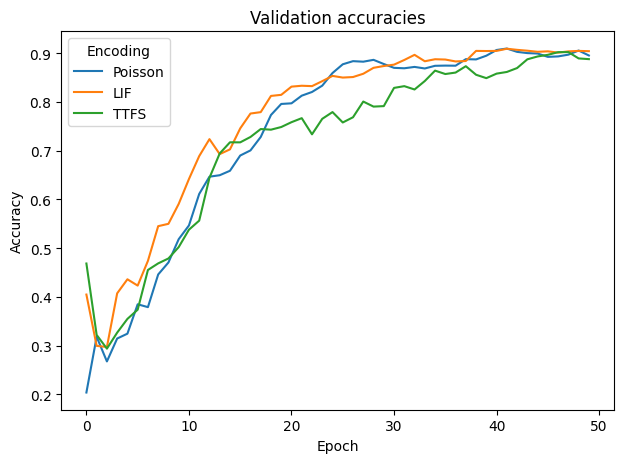

In [13]:
def smooth_series(series, window=5):
    return series.rolling(window=window, min_periods=1).mean()

tb_event_files = [
    glob(poisson_expe_folder + f'/5/**/**event**')[1],
    glob(lif_expe_folder + f'/5/**/**event**')[0],
    glob(ttfs_expe_folder + f'/5/**/**event**')[0],
]


for event_file, label in zip(tb_event_files, ['Poisson', 'LIF', 'TTFS']):
    df = get_event_df(event_file)
    val_acc = df[df['tag'] == f'val/acc'].copy()
    val_acc.loc[:, 'smoothed_value'] = smooth_series(val_acc['value'])

    sns.lineplot(data=val_acc, x='step', y='smoothed_value', label=label)

plt.title(f'Validation accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Encoding')
plt.rc('font', size=12)            # Base font size
plt.rc('axes', titlesize=12)      # Title size
plt.rc('axes', labelsize=12)       # Axis label size
plt.rc('xtick', labelsize=12)      # Tick label size
plt.rc('ytick', labelsize=12)      # Tick label size
plt.rc('legend', fontsize=12)      # Legend font size
plt.tight_layout()
plt.savefig(f'../figures/val_tmax_5_10.pdf', format='pdf', dpi=300)
plt.show()


In [14]:
tb_event_files_5 = [
    glob(poisson_expe_folder + f'/5/**/**event**')[1],
    glob(lif_expe_folder + f'/5/**/**event**')[0],
    glob(ttfs_expe_folder + f'/5/**/**event**')[0],
]

tb_event_files_10 = [
    glob(poisson_expe_folder + f'/10/**/**event**')[0],
    glob(lif_expe_folder + f'/10/**/**event**')[0],
    glob(ttfs_expe_folder + f'/10/**/**event**')[0],
]


poisson_df_5 = get_event_df(tb_event_files_5[0])
poisson_df_10 = get_event_df(tb_event_files_10[0])

ttfs_df_5 = get_event_df(tb_event_files_5[2])
ttfs_df_10 = get_event_df(tb_event_files_10[2])

lif_df_5 = get_event_df(tb_event_files_5[1])
lif_df_10 = get_event_df(tb_event_files_10[1])

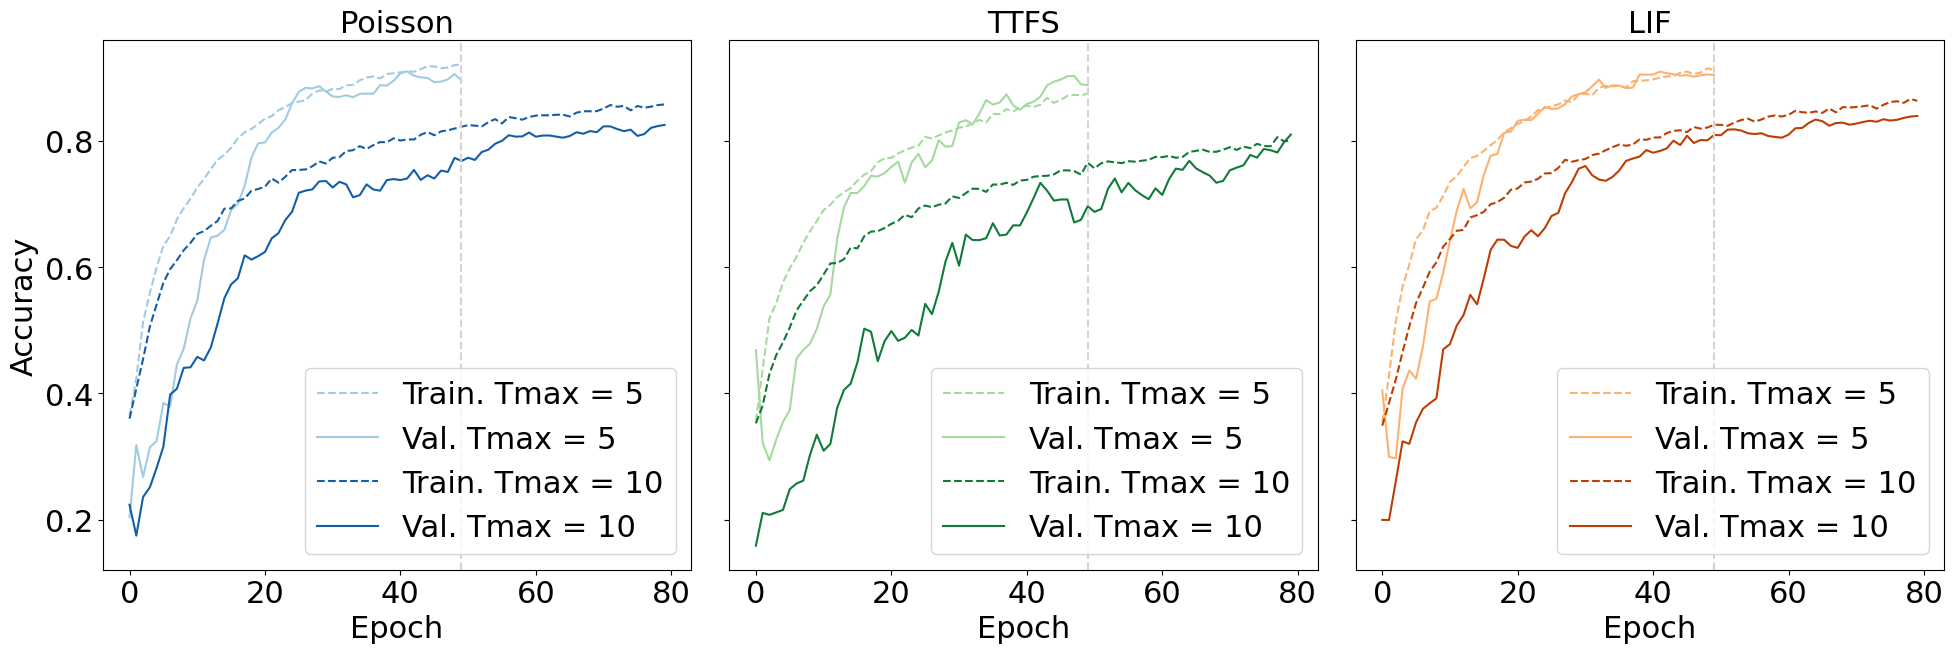

In [15]:
plt.rcParams.update({
    'font.size': 22,          # General font size
    'axes.titlesize': 22,     # Title font size
    'axes.labelsize': 22,     # X/Y label font size
    'legend.fontsize': 22,    # Legend font size
    'xtick.labelsize': 22,    # X-tick font size
    'ytick.labelsize': 22,    # Y-tick font size
})

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(20, 7)

# POISSON #
poisson_train_acc_10 = poisson_df_10[poisson_df_10['tag'] == f'train/acc'].copy()
poisson_val_acc_10 = poisson_df_10[poisson_df_10['tag'] == f'val/acc'].copy()

poisson_train_acc_5 = poisson_df_5[poisson_df_5['tag'] == f'train/acc'].copy()
poisson_val_acc_5 = poisson_df_5[poisson_df_5['tag'] == f'val/acc'].copy()

poisson_val_acc_5.loc[:, 'smoothed_value'] = smooth_series(poisson_val_acc_5['value'])
poisson_val_acc_10.loc[:, 'smoothed_value'] = smooth_series(poisson_val_acc_10['value'])


# LIF #
lif_train_acc_10 = lif_df_10[lif_df_10['tag'] == f'train/acc'].copy()
lif_val_acc_10 = lif_df_10[lif_df_10['tag'] == f'val/acc'].copy()

lif_train_acc_5 = lif_df_5[lif_df_5['tag'] == f'train/acc'].copy()
lif_val_acc_5 = lif_df_5[lif_df_5['tag'] == f'val/acc'].copy()

lif_val_acc_5.loc[:, 'smoothed_value'] = smooth_series(lif_val_acc_5['value'])
lif_val_acc_10.loc[:, 'smoothed_value'] = smooth_series(lif_val_acc_10['value'])

# TTFS #
ttfs_train_acc_10 = ttfs_df_10[ttfs_df_10['tag'] == f'train/acc'].copy()
ttfs_val_acc_10 = ttfs_df_10[ttfs_df_10['tag'] == f'val/acc'].copy()

ttfs_train_acc_5 = ttfs_df_5[ttfs_df_5['tag'] == f'train/acc'].copy()
ttfs_val_acc_5 = ttfs_df_5[ttfs_df_5['tag'] == f'val/acc'].copy()

ttfs_val_acc_5.loc[:, 'smoothed_value'] = smooth_series(ttfs_val_acc_5['value'])
ttfs_val_acc_10.loc[:, 'smoothed_value'] = smooth_series(ttfs_val_acc_10['value'])

poisson_colors = sns.color_palette("Blues", n_colors=10)
lif_colors = sns.color_palette("Oranges", n_colors=10)
ttfs_colors = sns.color_palette("Greens", n_colors=10)
greys = sns.color_palette("Greys", n_colors=10)

# POISSON #
sns.lineplot(ax=axes[0], data=poisson_train_acc_5, x='step', y='value', label='Train. Tmax = 5', linestyle='--', color=poisson_colors[3])
sns.lineplot(ax=axes[0], data=poisson_val_acc_5, x='step', y='smoothed_value', label='Val. Tmax = 5', color=poisson_colors[3])
sns.lineplot(ax=axes[0], data=poisson_train_acc_10, x='step', y='value', label='Train. Tmax = 10', linestyle='--', color=poisson_colors[8])
sns.lineplot(ax=axes[0], data=poisson_val_acc_10, x='step', y='smoothed_value', label='Val. Tmax = 10', color=poisson_colors[8])

# LIF #
sns.lineplot(ax=axes[2], data=lif_train_acc_5, x='step', y='value', label='Train. Tmax = 5', linestyle='--', color=lif_colors[3])
sns.lineplot(ax=axes[2], data=lif_val_acc_5, x='step', y='smoothed_value', label='Val. Tmax = 5', color=lif_colors[3])
sns.lineplot(ax=axes[2], data=lif_train_acc_10, x='step', y='value', label='Train. Tmax = 10', linestyle='--', color=lif_colors[8])
sns.lineplot(ax=axes[2], data=lif_val_acc_10, x='step', y='smoothed_value', label='Val. Tmax = 10', color=lif_colors[8])

# TTFS #
sns.lineplot(ax=axes[1], data=ttfs_train_acc_5, x='step', y='value', label='Train. Tmax = 5', linestyle='--', color=ttfs_colors[3])
sns.lineplot(ax=axes[1], data=ttfs_val_acc_5, x='step', y='smoothed_value', label='Val. Tmax = 5', color=ttfs_colors[3])
sns.lineplot(ax=axes[1], data=ttfs_train_acc_10, x='step', y='value', label='Train. Tmax = 10', linestyle='--', color=ttfs_colors[8])
sns.lineplot(ax=axes[1], data=ttfs_val_acc_10, x='step', y='smoothed_value', label='Val. Tmax = 10', color=ttfs_colors[8])
for ax in axes:
    ax.axvline(x=49, linestyle='--', color=greys[2], label='Step 49')
    
# Titles and labels
axes[0].set_title('Poisson')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')

axes[1].set_title('TTFS')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

axes[2].set_title('LIF')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')


plt.tight_layout()
plt.savefig('../figures/whole_acc_plot.pdf', format='pdf', dpi=600)
plt.show()


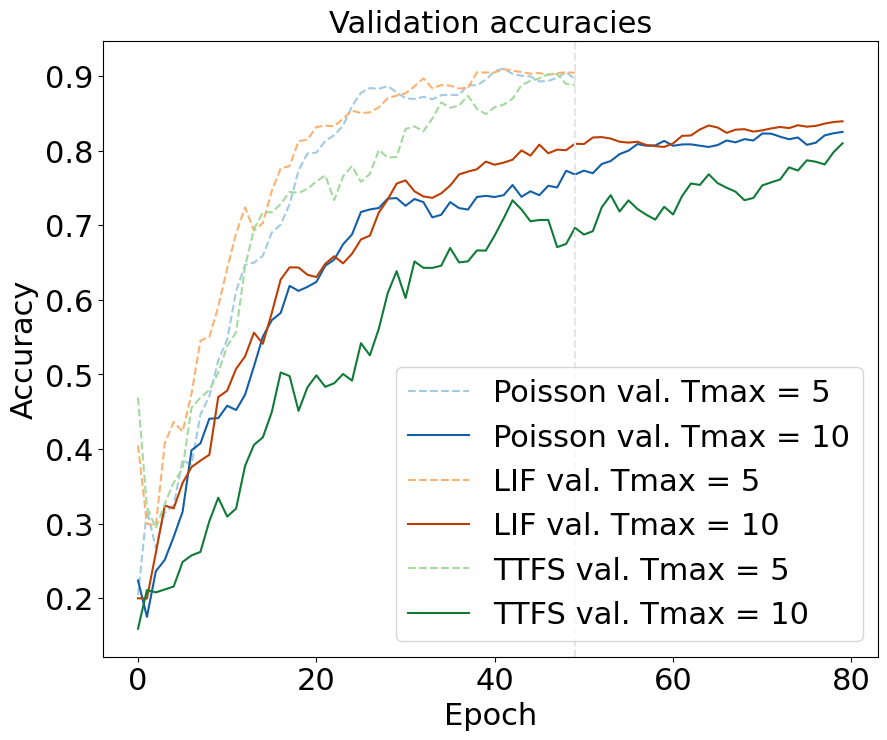

In [16]:
plt.rcParams.update({
    'font.size': 22,          # General font size
    'axes.titlesize': 22,     # Title font size
    'axes.labelsize': 22,     # X/Y label font size
    'legend.fontsize': 22,    # Legend font size
    'xtick.labelsize': 22,    # X-tick font size
    'ytick.labelsize': 22,    # Y-tick font size
})

plt.figure(figsize=(10, 8))

# POISSON #
sns.lineplot(data=poisson_val_acc_5, x='step', y='smoothed_value', label='Poisson val. Tmax = 5', linestyle='--', color=poisson_colors[3])
sns.lineplot(data=poisson_val_acc_10, x='step', y='smoothed_value', label='Poisson val. Tmax = 10', color=poisson_colors[8])

# LIF #
sns.lineplot(data=lif_val_acc_5, x='step', y='smoothed_value', label='LIF val. Tmax = 5', linestyle='--', color=lif_colors[3])
sns.lineplot(data=lif_val_acc_10, x='step', y='smoothed_value', label='LIF val. Tmax = 10', color=lif_colors[8])

# TTFS #
sns.lineplot(data=ttfs_val_acc_5, x='step', y='smoothed_value', label='TTFS val. Tmax = 5', linestyle='--', color=ttfs_colors[3])
sns.lineplot(data=ttfs_val_acc_10, x='step', y='smoothed_value', label='TTFS val. Tmax = 10', color=ttfs_colors[8])

# Add vertical line at step=49
plt.axvline(x=49, color=greys[1], linestyle='--', label='Step = 49')
    
# Titles and labels
plt.title('Validation accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('../figures/tmax_val_accuracies.pdf', format='pdf', dpi=300)
plt.show()



In [17]:
from glob import glob
import pandas as pd

tb_event_files_5 = [
    glob(poisson_expe_folder + f'/5/**/**event**'),
    glob(lif_expe_folder + f'/5/**/**event**'),
    glob(ttfs_expe_folder + f'/5/**/**event**'),
]

tb_event_files_10 = [
    glob(poisson_expe_folder + f'/10/**/**event**'),
    glob(lif_expe_folder + f'/10/**/**event**'),
    glob(ttfs_expe_folder + f'/10/**/**event**'),
]

poisson_colors = sns.color_palette("Blues", n_colors=10)
lif_colors = sns.color_palette("Oranges", n_colors=10)
ttfs_colors = sns.color_palette("Greens", n_colors=10)
greys = sns.color_palette("Greys", n_colors=10)

def get_average_df(expe_file_list):
    dfs = []
    for i in expe_file_list:
        df = get_event_df(i)
        df[df['tag'] == f'val/acc'].copy()
        dfs.append(df)
    
    combined_df = pd.concat(dfs)
    average_df = combined_df.groupby('step', as_index=False)['value'].mean()
    return average_df


poisson_average_5 = get_average_df(tb_event_files_5[0])
poisson_average_5.loc[:, 'smoothed_value'] = smooth_series(poisson_average_5['value'])
poisson_average_10 = get_average_df(tb_event_files_10[0])
poisson_average_10.loc[:, 'smoothed_value'] = smooth_series(poisson_average_10['value'])


lif_average_5 = get_average_df(tb_event_files_5[1])
lif_average_5.loc[:, 'smoothed_value'] = smooth_series(lif_average_5['value'])
lif_average_10 = get_average_df(tb_event_files_10[1])
lif_average_10.loc[:, 'smoothed_value'] = smooth_series(lif_average_10['value'])


ttfs_average_5 = get_average_df(tb_event_files_5[2])
ttfs_average_5.loc[:, 'smoothed_value'] = smooth_series(ttfs_average_5['value'])
ttfs_average_10 = get_average_df(tb_event_files_10[2])
ttfs_average_10.loc[:, 'smoothed_value'] = smooth_series(ttfs_average_10['value'])


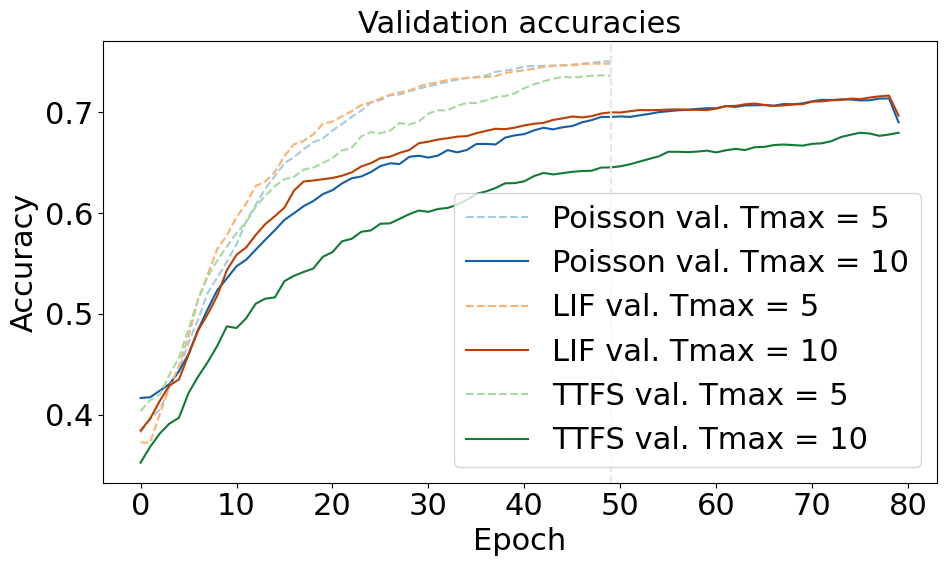

In [18]:
plt.figure(figsize=(10, 6))

# POISSON #
sns.lineplot(data=poisson_average_5, x='step', y='smoothed_value', label='Poisson val. Tmax = 5', linestyle='--', color=poisson_colors[3])
sns.lineplot(data=poisson_average_10, x='step', y='smoothed_value', label='Poisson val. Tmax = 10', color=poisson_colors[8])

# LIF #
sns.lineplot(data=lif_average_5, x='step', y='smoothed_value', label='LIF val. Tmax = 5', linestyle='--', color=lif_colors[3])
sns.lineplot(data=lif_average_10, x='step', y='smoothed_value', label='LIF val. Tmax = 10', color=lif_colors[8])

# TTFS #
sns.lineplot(data=ttfs_average_5, x='step', y='smoothed_value', label='TTFS val. Tmax = 5', linestyle='--', color=ttfs_colors[3])
sns.lineplot(data=ttfs_average_10, x='step', y='smoothed_value', label='TTFS val. Tmax = 10', color=ttfs_colors[8])

# Add vertical line at step=49
plt.axvline(x=49, color=greys[1], linestyle='--', label='Step = 49')
    
# Titles and labels
plt.title('Validation accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# General plot settings
plt.rc('font', size=18)            # Base font size
plt.rc('axes', titlesize=18)      # Title size
plt.rc('axes', labelsize=18)       # Axis label size
plt.rc('xtick', labelsize=18)      # Tick label size
plt.rc('ytick', labelsize=18)      # Tick label size
plt.rc('legend', fontsize=18)      # Legend font size

plt.tight_layout()
plt.savefig('../figures/tmax_val_accuracies.pdf', format='pdf', dpi=300)
plt.show()
